# Adversarial Example Generation

*Contact: Nagender Aneja, naneja@gmail.com, http://researchid.co/naneja

Fast Gradient Sign Attack, https://arxiv.org/abs/1412.6572

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torchvision import datasets, transforms

import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
pretrained_model = 'model/lenet_mnist_model.pth'
epsilons = [0, 0.05, .1, .15, .2, .25, .3]
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cpu


In [3]:
# LeNet Model definition
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

In [4]:
# MNIST Test dataset
tfs = [transforms.ToTensor()]
transform = transforms.Compose(tfs)
ds_test = datasets.MNIST(root='data', download=True, train=False, transform=transform)
loader_test = torch.utils.data.DataLoader(ds_test, batch_size=1, shuffle=True)

In [5]:
# Initialize the network
model = Net().to(device)

In [6]:
model.load_state_dict(torch.load(pretrained_model, map_location=device))
model.eval()

Net(
  (conv1): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))
  (conv2_drop): Dropout2d(p=0.5)
  (fc1): Linear(in_features=320, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=10, bias=True)
)

In [7]:
def fgsm_attack(image, epsilon, data_grad):
    sign_data_grad = data_grad.sign()
    perturbed_image = image + epsilon * sign_data_grad
    perturbed_image = torch.clamp(perturbed_image, 0, 1)
    return perturbed_image

In [8]:
def test(model, loader_test, epsilon):
    correct = 0
    adv_examples = []
    
    for data, target in loader_test:
        data, target = data.to(device), target.to(device)
        data.requires_grad = True # For attack
        
        output = model(data)
        pred_init = output.max(1, keepdim=True)[1]
        
        if pred_init.item() != target.item():
            continue # No Attack if model pred is not correct
        
        loss = F.nll_loss(output, target)
        loss.backward()
        
        data_grad = data.grad.data
        
        data = fgsm_attack(data, epsilon, data_grad)
        output = model(data)
        pred_final = output.max(1, keepdim=True)[1]
        
        if pred_final.item() != target.item():
            if len(adv_examples) < 5:
                adv_ex = data.squeeze().detach().cpu().numpy()
                adv_examples.append((pred_init.item(), pred_final.item(), adv_ex))
        else:
            correct += 1
            if len(adv_examples) < 5 and epsilon == 0: # save only when eps is 0 when attack not successful
                adv_ex = data.squeeze().detach().cpu().numpy()
                adv_examples.append((pred_init.item(), pred_final.item(), adv_ex))
    acc = correct*1.0 / len(loader_test)
    print('Eps: {} \t Accuracy = {}/{}={:.3f}'.format(epsilon, correct, len(loader_test), acc))
    return acc, adv_examples

In [9]:
accuracies = []
examples = []

for eps in epsilons:
    acc, ex = test(model, loader_test, eps)
    accuracies.append(acc)
    examples.append(ex)

Eps: 0 	 Accuracy = 9810/10000=0.981
Eps: 0.05 	 Accuracy = 9426/10000=0.943
Eps: 0.1 	 Accuracy = 8510/10000=0.851
Eps: 0.15 	 Accuracy = 6826/10000=0.683
Eps: 0.2 	 Accuracy = 4301/10000=0.430
Eps: 0.25 	 Accuracy = 2082/10000=0.208
Eps: 0.3 	 Accuracy = 869/10000=0.087


In [32]:
print(epsilons)
print(accuracies)

[0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3]
[0.981, 0.9426, 0.851, 0.6826, 0.4301, 0.2082, 0.0869]


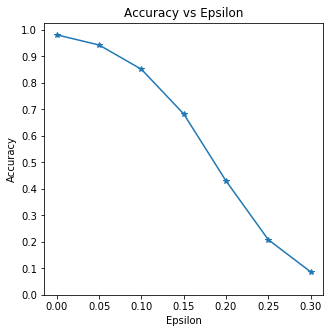

In [36]:
plt.figure(figsize=(5,5))

plt.plot(epsilons, accuracies, '*-')

plt.yticks(np.arange(0, 1.1, step=0.1))
plt.xticks(np.arange(0, .35, step=0.05))
plt.title("Accuracy vs Epsilon")
plt.xlabel("Epsilon")
plt.ylabel("Accuracy");

In [39]:
print(len(examples)) # number of epsilons
print(len(examples[0])) # number of examples

7
5


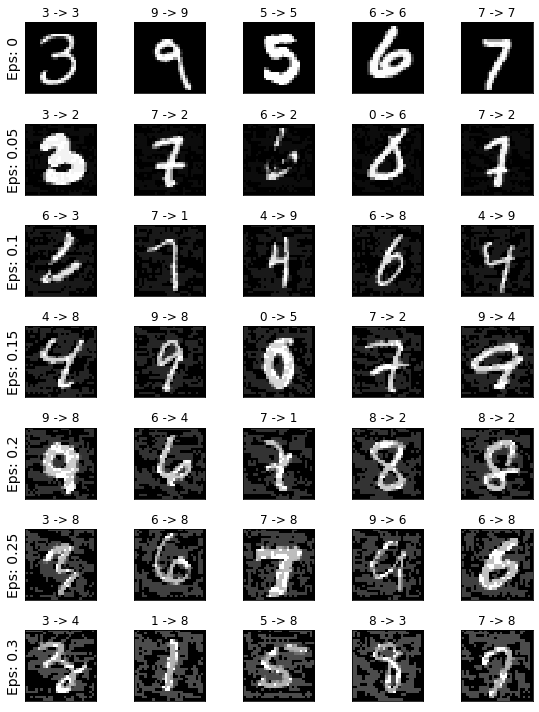

In [48]:
plt.figure(figsize=(8,10))

cnt = 0
for i in range(len(epsilons)):
    for j in range(len(examples[i])):
        cnt += 1
        plt.subplot(len(epsilons), len(examples[i]), cnt)
        orig, adv, ex = examples[i][j]

        plt.imshow(ex, cmap='gray')
        
        plt.xticks([], [])
        plt.yticks([], [])
        plt.title("{} -> {}".format(orig, adv))
        
        if j == 0:
            plt.ylabel("Eps: {}".format(epsilons[i]), fontsize=14)
        
plt.tight_layout()

## Dropout - note

In [10]:
# During training, randomly zeroes some of the elements of the input tensor with probability p using samples from a Bernoulli distribution. The elements to zero are randomized on every forward call.  Furthermore, the outputs are scaled by a factor of 1/(1-p) during training.
x = torch.ones(1, 10)
print(x)
model_1 = nn.Dropout(p=0.5) 
print(model_1)

# Train mode (default after construction)
model_1.train()
print(model_1(x))

# Eval mode
model_1.eval()
print(model_1(x))

tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])
Dropout(p=0.5)
tensor([[0., 2., 0., 0., 0., 0., 2., 2., 2., 2.]])
tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])
